## Imports

In [68]:
from JSU_lib import *

In [38]:
def parse_fpocket_output(filepath):
    # Read the content of the file
    with open(filepath, 'r') as file:
        data = file.read()
    
    # Regular expression to split the input data by "Pocket <number> :"
    pockets = re.split(r'Pocket \d+ :', data)
    pockets = [pocket.strip() for pocket in pockets if pocket.strip()]  # Remove any empty entries

    if pockets == []:
        return pd.DataFrame()

    # List to hold each pocket's dictionary of metrics
    pocket_list = []
    detail_keys = set()

    # Regex pattern to find all key-value pairs in each pocket's text block
    pattern = re.compile(r'(.*?):\s*([-\d\.]+)')

    for pocket in pockets:
        # Dictionary to store the data for this pocket
        pocket_data = {}
        
        # Find all key-value pairs in this pocket
        details = pattern.findall(pocket)
        for key, value in details:
            cleaned_key = key.strip().lower().replace(' - ', '_').replace(' ', '_').replace('.', '').replace('__', '_')
            pocket_data[cleaned_key] = float(value)
            detail_keys.add(cleaned_key)

        pocket_list.append(pocket_data)

    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(pocket_list)

    # Rename the DataFrame columns to the desired names
    df.columns = [
        'score', 'drug_score', 'n_alpha_spheres',
        'total_sasa', 'polar_sasa', 'apolar_sasa', 'volume',
        'mean_hydro_density', 'mean_alpha_sphere_r',
        'mean_alpha_sphere_solvent_acc', 'apolar_alpha_sphere_prop',
        'hydro_score', 'vol_score', 'polarity_score', 'charge_score',
        'prop_polar_atoms', 'alpha_sphere_density', 'max_dist', 'flexibility'
    ]

    # Add ID column, starting at 1 and incrementing by 1 for each row
    df["ID"] = list(range(1, len(df)+1))

    # Add a RANK column based on the 'drug_score', highest first
    df['RANK'] = df['score'].rank(ascending=False, method='first').astype(int)

    return df

def plot_hexbin(x, y, xlab, ylab, xlim = None, ylim = None, x_text_coord = 5, y_text_coord = 0.5, gridsize=1000, cmap='viridis', addTline=True, addcorr = False):
    plt.figure(figsize=(8, 6))
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, bins='log')
    plt.colorbar()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    if addTline:
        plt.axhline(y=1, linestyle = "--", color = "k")

    if addcorr:
        r, p = pearsonr(x, y)
        slope, intercept = np.polyfit(x, y, 1)
        line = slope * np.array([min(x), max(x)]) + intercept
        plt.plot([min(x), max(x)], line, color='r', lw=0.5)
        
        # Annotations for r, p-value, CI, and minimum count
        plt.text(x_text_coord, y_text_coord, 'r={:.2f}, p={:.3f}'.format(r, p),
                      color='k', fontsize=12)

    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    plt.show()

In [46]:
trans_rep_chains_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/DATA/trans_rep_chains"

In [47]:
fpocket_out_dirs = sorted([el for el in os.listdir(trans_rep_chains_dir) if el.endswith("out")])

In [48]:
len(fpocket_out_dirs)

4435

In [49]:
fpocket_out_dirs[:5]

['1a52_A.trans_out',
 '1a5h_B.trans_out',
 '1a9w_E.trans_out',
 '1ags_B.trans_out',
 '1aii_A.trans_out']

## Get Pocket descriptors

In [50]:
errors = []
success = []
no_pockets = []
fpocket_dfs = []

In [51]:
for i, fpocket_dir in enumerate(fpocket_out_dirs):
    
    #if i % 100 == 0:
    #    print(i) 
    
    if fpocket_dir in success:
        continue
        
    try:
        fpocket_dir_path = os.path.join(trans_rep_chains_dir, fpocket_dir)
        input_name = fpocket_dir[:-4]
        file_path = os.path.join(fpocket_dir_path, f'{input_name}_info.txt')
        pocket_df = parse_fpocket_output(file_path)
        
        if pocket_df.empty:
            #print(f'No pockets in {input_name}')
            if fpocket_dir not in no_pockets:
                no_pockets.append(fpocket_dir)
            continue
        
        pocket_df["rep_chain"] = input_name.split(".")[0]
        success.append(fpocket_dir)
        fpocket_dfs.append(pocket_df)
    except:
        print(f'ERROR with {fpocket_dir}')
        #raise
        if fpocket_dir not in errors:
            errors.append(fpocket_dir)
        
        

In [52]:
print(len(success)) #4378
print(len(no_pockets)) #57
print(len(fpocket_dfs)) #4378
print(len(errors)) #0

4378
57
4378
0


In [53]:
all_fpockets = pd.concat(fpocket_dfs).reset_index(drop = True)

In [54]:
all_fpockets.columns

Index(['score', 'drug_score', 'n_alpha_spheres', 'total_sasa', 'polar_sasa',
       'apolar_sasa', 'volume', 'mean_hydro_density', 'mean_alpha_sphere_r',
       'mean_alpha_sphere_solvent_acc', 'apolar_alpha_sphere_prop',
       'hydro_score', 'vol_score', 'polarity_score', 'charge_score',
       'prop_polar_atoms', 'alpha_sphere_density', 'max_dist', 'flexibility',
       'ID', 'RANK', 'rep_chain'],
      dtype='object')

In [55]:
fpocket_cols = ["rep_chain", "ID", "RANK", "score", "drug_score", "total_sasa", "volume"]

In [43]:
#all_fpockets.to_pickle("./results/fpocket_pockets.pkl")

In [94]:
#all_fpockets = pd.read_pickle("./results/fpocket_pockets.pkl")

## Get pocket residues

In [56]:
errors = []
success = []
no_pockets = []
fpocket_ress_dict = {}
centres_dict = {}

In [60]:
for i, fpocket_dir in enumerate(fpocket_out_dirs):
    
    if i % 100 == 0:
        print(i) 
    
    if fpocket_dir in success:
        continue
        
    try:
        fpocket_dir_path = os.path.join(trans_rep_chains_dir, fpocket_dir)
        input_name = fpocket_dir[:-4]
        rep_chain = input_name.split(".")[0]
        #print(input_name)
        pockets_dir = os.path.join(fpocket_dir_path, "pockets")
        pockets_pdb = [el for el in os.listdir(pockets_dir) if el.endswith(".pdb")]
        #print(pockets_pdb)
        for pocket_file in pockets_pdb:
            pocket_id = int(pocket_file.split("_")[0][6:])
            pocket_path = os.path.join(pockets_dir, pocket_file)
            pocket_df = PDBXreader(inputfile=pocket_path).atoms(format_type="pdb", excluded=())
            pocket_ress = sorted(pocket_df.label_seq_id_full.unique().tolist(), key=custom_sort)
            fpocket_ress_dict[(rep_chain, pocket_id)] = pocket_ress

            pocket_coords = np.array(list((zip(pocket_df.Cartn_x, pocket_df.Cartn_y, pocket_df.Cartn_z))))
            center_of_mass = np.mean(pocket_coords, axis=0)
            centres_dict[(rep_chain, pocket_id)] = tuple([round(v, 3) for v in center_of_mass])
            
        #break
        
        if pocket_df.empty:
            #print(f'No pockets in {input_name}')
            if fpocket_dir not in no_pockets:
                no_pockets.append(fpocket_dir)
            continue
            
        success.append(fpocket_dir)
    except:
        raise
        print(f'ERROR with {fpocket_dir}')
        if fpocket_dir not in errors:
            errors.append(fpocket_dir)
    #break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400


In [61]:
print(len(success)) #4435 
print(len(no_pockets)) #0
print(len(fpocket_ress_dict)) #84390
print(len(centres_dict)) #84390
print(len(errors)) #0

4435
0
84390
84390
4378


In [62]:
success_reps = [el.split(".")[0] for el in success]

In [63]:
LIGYSIS_reps = read_from_pickle("./results/LIGYSIS_3448_chains.pkl")

In [64]:
len(set(LIGYSIS_reps).intersection(set(success_reps))) #3448

3448

In [65]:
save_to_pickle(fpocket_ress_dict, "./results/fpocket_pocket_ress_TRANS.pkl")
save_to_pickle(centres_dict, "./results/fpocket_pocket_centres_TRANS.pkl")

In [66]:
all_fpockets["aas"] = all_fpockets.set_index(["rep_chain", "ID"]).index.map(fpocket_ress_dict)

In [67]:
centres = []
errs = 0
for i, row in all_fpockets.iterrows():
    try:
        centre = centres_dict[(row.rep_chain, row.RANK)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
print(errs)

all_fpockets["centre"] = centres

0


In [69]:
all_fpockets["n_aas"] = all_fpockets['aas'].apply(lambda x: len(x)) 

## Calculate RoG of fpocket pockets

In [70]:
site_targets = all_fpockets.rep_chain.unique().tolist()
len(site_targets)

4378

In [71]:
all_fpockets.shape[0]

84390

In [72]:
target_dir = './../DATA/trans_rep_chains'

In [73]:
cc = [
    'label_seq_id_full', 'label_comp_id', 'type_symbol',
    'label_atom_id', 'Cartn_x', 'Cartn_y', 'Cartn_z'
]

In [74]:
T0 = time.time()
RoG_dict = {}
for i, target in enumerate(site_targets):
    if i % 500 == 0:
        print(i)
    pdb_path = os.path.join(target_dir, f'{target}.trans.pdb')
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    #df.label_seq_id = df.label_seq_id.astype(int)
    target_sites_df = all_fpockets.query('rep_chain == @target')
    #print(len(acc_sites_df))
    for _, row in target_sites_df.iterrows():
        site_ress = row.aas
        #print(site_ress)
        ress_CAs = df.query('label_seq_id_full in @site_ress')
        CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
        center_of_mass = np.mean(CAs_coords, axis=0)
        distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
        radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
        RoG_dict[(target, row["ID"])] = radius_of_gyration

    #break
TF = time.time()

0
500
1000
1500
2000
2500
3000
3500
4000


In [75]:
dTs = TF-T0

dTm = dTs/60

N_RoG = len(RoG_dict)

print(N_RoG)

print(round(dTm,2))

print(round(dTs/N_RoG, 5))

84390
7.08
0.00504


In [128]:
save_to_pickle(RoG_dict, "./results/fpocket_RoG_TRANS.pkl")

In [77]:
all_fpockets["RoG"] = all_fpockets.set_index(['rep_chain', 'ID']).index.map(RoG_dict)

In [78]:
all_fpockets[fpocket_cols+["aas", "n_aas", "centre", "RoG"]].head(3)

,rep_chain,ID,RANK,score,drug_score,total_sasa,volume,aas,n_aas,centre,RoG
0,1a52_A,1,1,0.268,0.996,336.777,1218.873,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...",32,"(-4.199, -6.401, 0.526)",11.82
1,1a52_A,2,2,0.120,0.000,82.334,364.130,"[34, 35, 36, 39, 40, 41, 44, 45, 48, 49, 52]",11,"(3.676, -20.883, 5.447)",6.86
2,1a52_A,3,3,0.111,0.024,193.766,714.792,"[17, 20, 21, 142, 143, 145, 147, 148, 193, 194...",14,"(11.031, 16.01, 3.905)",8.41


## Mapping PDB residues to UP residues

In [79]:
up_aas = {}
errors = []
no_sifts = []
for _, row in all_fpockets.iterrows():
    b = 0
    rep_chain = row.rep_chain
    site_ress = row.aas
    rank = row["RANK"]
    try:
        mapping_dict = read_from_pickle(f'./../DATA/mappings_label_full/{rep_chain}.pkl')
    except:
        no_sifts.append(rep_chain)
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors.append(rep_chain)
            b = 1
            break
    if b ==1:
        continue
    up_aas[(rep_chain, rank)] = site_up_aas

In [80]:
print(len(up_aas)) #81246
print(len(errors)) #3144
print(len(no_sifts)) #4576
errors = list(set(errors)) # 31chains have issues with SIFTS mapping, e.g, 1nav_A. For some reason, the last 40 residues lack residue mapping to UniProt
print(len(errors)) #806
save_to_pickle(errors, "./results/fpocket_no_sifts_TRANS.pkl")

81246
3144
4576
806


In [81]:
all_fpockets_w_sifts = all_fpockets.query('rep_chain not in @errors').copy().reset_index(drop = True)
all_fpockets_w_sifts["up_aas"] = all_fpockets_w_sifts.set_index(['rep_chain', 'RANK']).index.map(up_aas)

all_fpockets_w_sifts["n_up_aas"] = all_fpockets_w_sifts['up_aas'].apply(lambda x: len(x))
assert all_fpockets_w_sifts.n_aas.equals(all_fpockets_w_sifts.n_up_aas)
all_fpockets_w_sifts.drop(columns = ["n_up_aas"], inplace = True)

In [82]:
fpocket_cols = fpocket_cols + ["n_aas", "centre", "RoG", "aas", "up_aas"]

In [83]:
all_fpockets_w_sifts[fpocket_cols].head(5)

,rep_chain,ID,RANK,score,drug_score,total_sasa,volume,n_aas,centre,RoG,aas,up_aas
0,1a52_A,1,1,0.268,0.996,336.777,1218.873,32,"(-4.199, -6.401, 0.526)",11.82,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7...","[343, 346, 347, 349, 350, 351, 353, 354, 358, ..."
1,1a52_A,2,2,0.120,0.000,82.334,364.130,11,"(3.676, -20.883, 5.447)",6.86,"[34, 35, 36, 39, 40, 41, 44, 45, 48, 49, 52]","[330, 331, 332, 335, 336, 337, 340, 341, 344, ..."
2,1a52_A,3,3,0.111,0.024,193.766,714.792,14,"(11.031, 16.01, 3.905)",8.41,"[17, 20, 21, 142, 143, 145, 147, 148, 193, 194...","[313, 316, 317, 438, 439, 441, 443, 444, 489, ..."
3,1a52_A,4,4,0.086,0.041,129.477,466.333,15,"(1.479, -0.948, 6.948)",7.62,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9...","[323, 324, 325, 326, 327, 353, 356, 357, 386, ..."
4,1a52_A,5,5,0.055,0.004,115.814,445.439,10,"(-1.437, 8.638, -6.879)",6.97,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ...","[451, 452, 455, 456, 479, 483, 508, 511, 512, ..."


In [84]:
len(all_fpockets_w_sifts.rep_chain.unique()) #3572

3572

In [85]:
len(set(LIGYSIS_reps).intersection(set(list(all_fpockets_w_sifts.rep_chain.unique())))) #2931

2931

In [86]:
#all_fpockets_w_sifts.to_pickle("./results/fpocket_pockets_sifted_V2.pkl")

## Add pocket surface and volume

In [88]:
bad_reps = read_from_pickle("./results/OLD/other_errrors_reps.pkl")

#all_fpockets_w_sifts = pd.read_pickle("./results/fpocket_pockets_sifted_V2.pkl")

master_SASA_dict = read_from_pickle("./results/master_SASA_dict.pkl")

all_fpockets_w_sifts_SASA = calculate_total_sasa(all_fpockets_w_sifts, master_SASA_dict)

vols_dict = read_from_pickle("./results/fpocket_volumes_dict.pkl")

all_fpockets_w_sifts_SASA["VOL"] = all_fpockets_w_sifts_SASA.set_index(['rep_chain', 'ID']).index.map(vols_dict)

In [89]:
avg_max_sasa

202.0

In [90]:
all_fpockets_w_sifts_SASA.query('SASA != SASA & rep_chain not in @bad_reps & n_aas != 0') 

,score,drug_score,n_alpha_spheres,total_sasa,polar_sasa,apolar_sasa,volume,mean_hydro_density,mean_alpha_sphere_r,mean_alpha_sphere_solvent_acc,...,ID,RANK,rep_chain,aas,centre,n_aas,RoG,up_aas,SASA,VOL


In [91]:
all_fpockets_w_sifts_SASA.to_pickle("./results/fpocket_pockets_DEF_TRANS.pkl")

In [99]:
all_fpockets_w_sifts_SASA.columns

Index(['score', 'drug_score', 'n_alpha_spheres', 'total_sasa', 'polar_sasa',
       'apolar_sasa', 'volume', 'mean_hydro_density', 'mean_alpha_sphere_r',
       'mean_alpha_sphere_solvent_acc', 'apolar_alpha_sphere_prop',
       'hydro_score', 'vol_score', 'polarity_score', 'charge_score',
       'prop_polar_atoms', 'alpha_sphere_density', 'max_dist', 'flexibility',
       'ID', 'RANK', 'rep_chain', 'aas', 'centre', 'n_aas', 'RoG', 'up_aas',
       'SASA', 'VOL'],
      dtype='object')

In [101]:
all_fpockets_w_sifts_SASA[["rep_chain", "RANK", "score", "total_sasa", "SASA", "volume", "VOL", "aas"]]

,rep_chain,RANK,score,total_sasa,SASA,volume,VOL,aas
0,1a52_A,1,0.268,336.777,1388.33,1218.873,1981,"[47, 50, 51, 53, 54, 55, 57, 58, 62, 66, 71, 7..."
1,1a52_A,2,0.120,82.334,792.26,364.130,244,"[34, 35, 36, 39, 40, 41, 44, 45, 48, 49, 52]"
2,1a52_A,3,0.111,193.766,744.08,714.792,304,"[17, 20, 21, 142, 143, 145, 147, 148, 193, 194..."
3,1a52_A,4,0.086,129.477,559.21,466.333,399,"[27, 28, 29, 30, 31, 57, 60, 61, 90, 91, 94, 9..."
4,1a52_A,5,0.055,115.814,348.38,445.439,413,"[155, 156, 159, 160, 183, 187, 212, 215, 216, ..."
...,...,...,...,...,...,...,...,...
72337,8yhh_B,22,-0.026,85.188,347.01,296.222,95,"[223, 224, 227, 233, 234, 235]"
72338,8yhh_B,23,-0.039,173.836,682.37,526.418,290,"[106, 109, 235, 236, 269, 270, 271, 272, 291, ..."
72339,8yhh_B,24,-0.058,69.362,382.34,184.189,41,"[173, 174, 175, 176, 218, 221, 222]"
72340,8yhh_B,25,-0.064,139.088,894.06,608.181,959,"[159, 187, 189, 191, 196, 197, 198, 199, 200, ..."


In [102]:
print(all_fpockets_w_sifts_SASA.total_sasa.min(), all_fpockets_w_sifts_SASA.total_sasa.max())
print(all_fpockets_w_sifts_SASA.SASA.min(), all_fpockets_w_sifts_SASA.SASA.max())

2.415 2113.359
13.010000000000002 6026.9299999999985


In [103]:
all_fpockets_w_sifts_SASA.total_sasa.min()

2.415

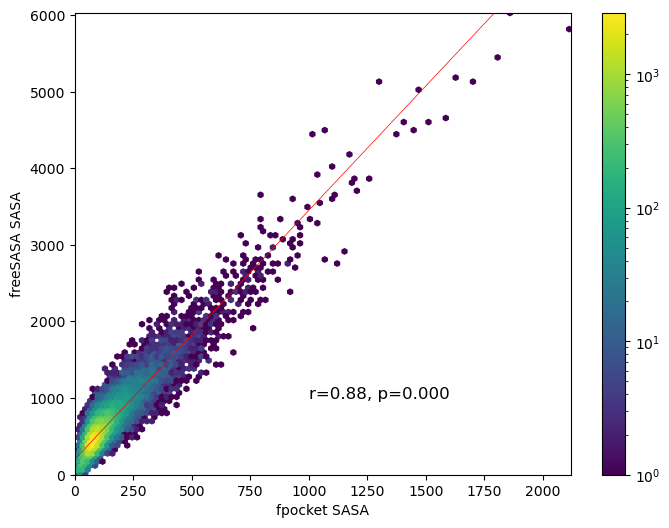

In [104]:
plot_hexbin(
    combined_SASA_df.query('SASA != 0').total_sasa.tolist(),
    combined_SASA_df.query('SASA != 0').SASA.tolist(),
    xlab = "fpocket SASA",
    ylab = "freeSASA SASA",
    xlim = (0, 2120), ylim = (0, 6030),
    x_text_coord = 1000, y_text_coord = 1000, gridsize=100, cmap='viridis', addTline=False, addcorr = True)

In [106]:
print(all_fpockets_w_sifts_SASA.volume.min(), all_fpockets_w_sifts_SASA.volume.max())
print(all_fpockets_w_sifts_SASA.VOL.min(), all_fpockets_w_sifts_SASA.VOL.max())

46.303 8288.43
0 20341


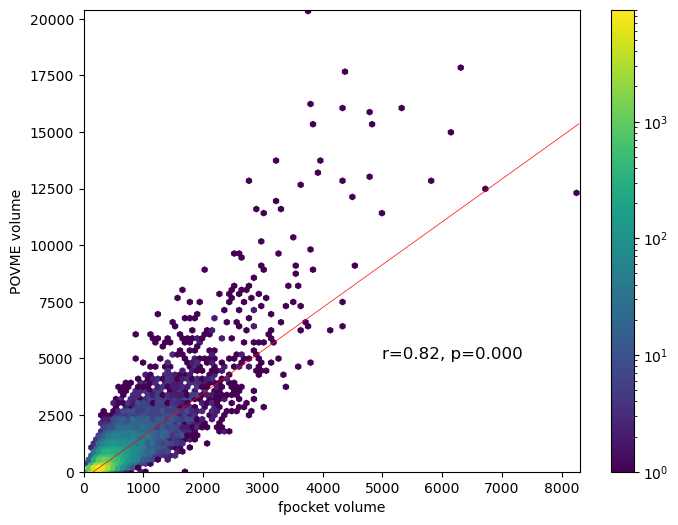

In [107]:
plot_hexbin(
    all_fpockets_w_sifts_SASA.query('SASA != 0').volume.tolist(),
    all_fpockets_w_sifts_SASA.query('SASA != 0').VOL.tolist(),
    xlab = "fpocket volume",
    ylab = "POVME volume",
    xlim = (0, 8300), ylim = (0, 20400),
    x_text_coord = 5000, y_text_coord = 5000, gridsize=100, cmap='viridis', addTline=False, addcorr = True)

In [108]:
all_fpockets_w_sifts_SASA["vol_diff"] = all_fpockets_w_sifts_SASA.VOL - all_fpockets_w_sifts_SASA.volume

In [116]:
all_fpockets_w_sifts_SASA["SASA_diff"] = all_fpockets_w_sifts_SASA.SASA - all_fpockets_w_sifts_SASA.total_sasa

In [109]:
all_fpockets_w_sifts_SASA[["rep_chain", "RANK", "score", "total_sasa", "SASA", "volume", "VOL", "vol_diff", "aas"]].sort_values(by=["vol_diff"], ascending = False)

,rep_chain,RANK,score,total_sasa,SASA,volume,VOL,vol_diff,aas
56232,7mix_A,1,1.161,1061.035,2820.15,3724.729,20341,16616.271,"[229, 232, 233, 235, 236, 237, 240, 320, 321, ..."
66474,8ajo_A,100,-1.261,1505.433,4610.15,4392.094,17578,13185.906,"[31, 32, 33, 34, 380, 383, 385, 386, 387, 388,..."
48119,6vhh_A,85,-0.137,935.423,2726.32,3772.596,16236,12463.404,"[186, 187, 188, 189, 190, 191, 193, 194, 195, ..."
33018,5o9z_C,115,-1.668,1440.087,4509.17,4364.053,16061,11696.947,"[1191, 1192, 1193, 1194, 1195, 1196, 1199, 129..."
71745,8tar_N,24,-1.458,1702.430,5159.80,6302.484,17859,11556.516,"[169, 170, 173, 174, 177, 178, 181, 182, 256, ..."
...,...,...,...,...,...,...,...,...,...
4589,1uwy_A,3,0.119,382.244,1610.96,1413.932,552,-861.932,"[3, 4, 5, 119, 120, 121, 122, 177, 216, 218, 2..."
8035,2ghf_A,1,0.694,191.617,951.78,915.037,0,-915.037,"[16, 17, 18, 19, 23, 29, 31, 34, 35, 38, 45, 5..."
70996,8iys_R,13,-0.226,334.848,1196.13,961.342,0,-961.342,"[53, 57, 60, 61, 64, 65, 67, 68, 136, 265, 266..."
21691,4e4m_B,3,0.114,232.272,1097.27,1006.195,25,-981.195,"[150, 180, 182, 183, 184, 185, 186, 187, 188, ..."


In [36]:
"+".join(
    combined_SASA_df.sort_values(
        by=["vol_diff"], ascending = False
    ).loc[66474, "aas"]
)

'31+32+33+34+380+383+385+386+387+388+394+396+399+401+412+414+415+416+417+627+628+629+635+636+637+651+652+653+654+655+662+673+674+675+679+681+682+683+686+687+688+689+690+691+692+693+694+733+734+735+736+1030+1031+1032+1035+1036+1037+1038+1053+1054+1055+1059+1060+1061+1062+1063+1078+1081+1082+1085+1086+1087+1088+1115+1116+1117+1118+1119+1120+1121+1122+1124+1126+1128+1129+1132+1133+1136+1137+1138+1139+1140+1146+1147+1148+1149+1150+1152+1153+1154+1155+1156+1157+1158+1159+1160+1161+1162+1164'

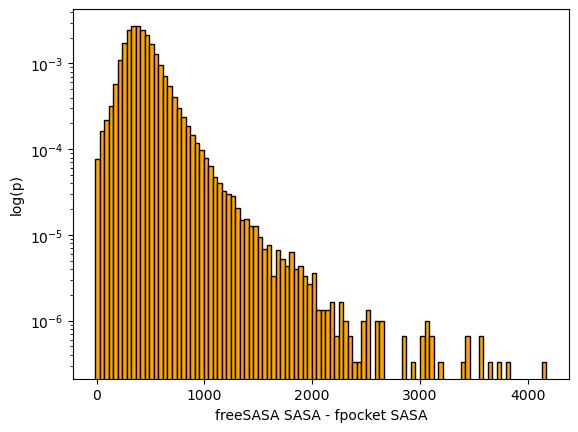

In [127]:
plt.hist(all_fpockets_w_sifts_SASA.SASA_diff, bins = 100, density = True, edgecolor = "k", color = "orange")
#plt.xlim(-30, 20)
plt.xlabel("freeSASA SASA - fpocket SASA")
plt.ylabel("log(p)")
plt.yscale("log")
plt.show()

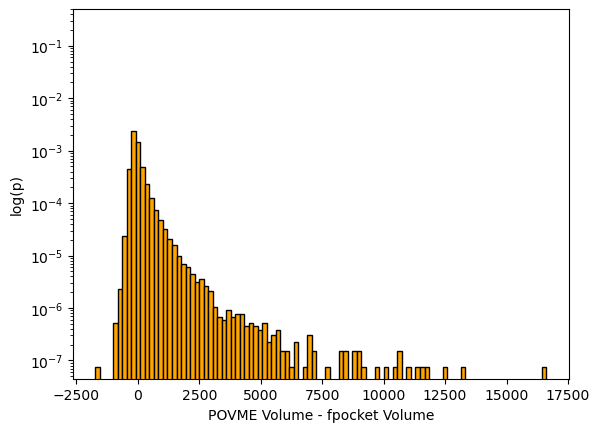

In [126]:
plt.hist(all_fpockets_w_sifts_SASA.vol_diff, bins = 100, density = True, edgecolor = "k", color = "orange")
#plt.xlim(-30, 20)
plt.xlabel("POVME Volume - fpocket Volume")
plt.ylabel("log(p)")
plt.yscale("log")
plt.ylim(0,0.5)
plt.show()